In [1]:
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
from sklearn import decomposition as skldec #用于主成分分析降维的包
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
pop=['2000Pop','2001Pop','2002Pop','2003Pop','2004Pop','2005Pop','2006Pop','2007Pop','2008Pop','2009Pop',
     '2010Pop','2011Pop','2012Pop','2013Pop','2014Pop','2015Pop','2016Pop','2017Pop']
gdp=['2000GDP','2001GDP','2002GDP','2003GDP','2004GDP','2005GDP','2006GDP','2007GDP','2008GDP','2009GDP',
     '2010GDP','2011GDP','2012GDP','2013GDP','2014GDP','2015GDP','2016GDP','2017GDP']
area=['2000Area','2001Area','2002Area','2003Area','2004Area','2005Area','2006Area','2007Area','2008Area','2009Area',
     '2010Area','2011Area','2012Area','2013Area','2014Area','2015Area','2016Area','2017Area']
roadleng=['2000Roadleng','2001Roadleng','2002Roadleng','2003Roadleng','2004Roadleng','2005Roadleng','2006Roadleng','2007Roadleng','2008Roadleng','2009Roadleng',
     '2010Roadleng','2011Roadleng','2012Roadleng','2013Roadleng','2014Roadleng','2015Roadleng','2016Roadleng','2017Roadleng']
inv_times=['2000invtime','2001invtime','2002invtime','2003invtime','2004invtime','2005invtime','2006invtime','2007invtime','2008invtime','2009invtime',
     '2010invtime','2011invtime','2012invtime','2013invtime','2014invtime','2015invtime','2016invtime','2017invtime']
investment=['2000inv','2001inv','2002inv','2003inv','2004inv','2005inv','2006inv','2007inv','2008inv','2009inv',
     '2010inv','2011inv','2012inv','2013inv','2014inv','2015inv','2016inv','2017inv']

In [9]:
data =pd.read_excel('E:/文档系列/python 系列/TheData/0_theDATA_end(1991-2017pop&GDP&vc)/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [20]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###保存所有的log值，小于0的记录为-1
    p2=[]
    g2=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log(XI)
    yi=np.log(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
    return(City)
cityM = GuiJI(data,pop,investment,15,'pop','amount')###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


In [21]:
dataM = pd.DataFrame(columns=data.columns)
for cc in range(len(city)):
    if city[cc] in cityM:
#         print(cc)
        dataM.loc[cc] = list(data[cc:cc+1].values[0])

In [44]:
dataPOP=dataM.iloc[:,3:21].fillna(0)###获取POP的数据
dataPOP.index=np.arange(0,dataPOP.shape[0])
dataGDP=dataM.iloc[:,22:40].fillna(0)###获取GDP的数据
dataGDP.index=np.arange(0,dataGDP.shape[0])
dataAmount = dataM.iloc[:,50:68].fillna(0)###投资金额
dataAmount.index=np.arange(0,dataAmount.shape[0])
dataTimes = dataM.iloc[:,77:95].fillna(0)###投资次数
dataTimes.index=np.arange(0,dataTimes.shape[0])

In [45]:
### 获得双对数的值 ，舍掉双对数中的0值###
def get_log3(inv,g,DATA,data2,city):###读取两年的数据，将两年都有数据的城市保存下来
    y_investment=np.log10(DATA[inv])###当年数据
    y_gdp=np.log10(data2[g])
    y_investment2=y_investment.fillna(np.infty)
    y_gdp2=y_gdp.fillna(np.infty)
    x1=[]###保存两年都存在的城市的当年的数据
    y1=[]
    X1=[]###保存两年都存在的城市的当年的原数据
    Y1=[]
    CITY=[]###保存有数据的城市名
    for xi in range(len(y_investment2)):
        if y_investment2[xi]==-float('Inf') or y_investment2[xi]==float('Inf') or y_gdp2[xi]==-float('Inf') or y_gdp2[xi]==float('Inf'):
#             X1.append(DATA[inv][xi])
#             Y1.append(DATA[g][xi])
#             print('inf...')
            continue
#         elif xi>-4:
        else:
            x1.append(y_investment2[xi])
            y1.append(y_gdp2[xi])
#             X1.append(DATA[inv][xi])
#             Y1.append(DATA[g][xi])
            CITY.append(city[xi])
    return(x1,y1,CITY)

In [46]:
### 6.最小二乘拟合
from scipy.optimize import leastsq  ##引入最小二乘法算法
from sklearn.metrics import r2_score
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y
def pic(yt1,yt2,city,City):
#     yt1=yt[0]
#     yt2=yt[1]Z
,
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(yt1)
    Yi=np.array(yt2)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点

    #读取结果
    k,b=Para[0]
    y = [k*x+b for x in yt1]
    sami = [yt2[xx]-y[xx] for xx in range(len(yt2))] ###某一年211个城市的残差
    Sami = [0 for jj in range(len(city))]###初始化，211个城市的残差
    for c in range(len(city)):
#         count = 0 ###记录查看了多少次，如果查找了211次还没找到，则该城市的残差赋值为0
        for c2 in range(len(City)):
            if city[c] == City[c2]:
                Sami[c] = sami[c2]
#     k1=round(k, 2)
    return(Sami)


In [43]:
###### 得到2000-2016年211个城市的残差序列 #########
dataAmount[0:1]

,2000inv,2001inv,2002inv,2003inv,2004inv,2005inv,2006inv,2007inv,2008inv,2009inv,2010inv,2011inv,2012inv,2013inv,2014inv,2015inv,2016inv,2017inv
0,948.3876,3295.534374,1270.291932,981.121198,1971.053884,55584.511998,100514.601997,29356.535646,33039.714482,71820.515097,79137.531613,107968.531205,40271.403246,60338.222907,63233.403198,70934.245154,55247.33865,62377.521492


In [50]:
AllSami_A = []###保存残差序列情况
AllSami_T = []
AllSami_G = []
for i in range(len(pop)):
    aaA = get_log3(pop[i],investment[i],dataPOP,dataAmount,cityM)
    bbA = pic(aaA[0],aaA[1],cityM,aaA[2])###得到某一年的残差序列
    AllSami_A.append(bbA)
    
    aaT = get_log3(pop[i],inv_times[i],dataPOP,dataTimes,cityM)
    bbT = pic(aaT[0],aaT[1],cityM,aaT[2])###得到某一年的残差序列
    AllSami_T.append(bbT)
    
    aaG = get_log3(pop[i],gdp[i],dataPOP,dataGDP,cityM)
    bbG = pic(aaG[0],aaG[1],cityM,aaG[2])###得到某一年的残差序列
    AllSami_G.append(bbG)
dfSami_A = pd.DataFrame(AllSami_A)
dfSami_T = pd.DataFrame(AllSami_T)
dfSami_G = pd.DataFrame(AllSami_G)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [54]:
dfSami_G.shape[1]

149

In [58]:
####计算城市自己的相关性 Ai(Dt) = 1DjiD2Xtji(t)ji(tzDt)
def Anum(data,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值   
    POP = data.iloc[m:m+1,0:17].values[0]###时间序列长度必须一致，每次往后挪一列
    a = 0
    for xx in range(len(POP)):
        a += POP[xx]**2
    for i in range(16):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,i:17].values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data.iloc[m:m+1,i+1:18].values[0]
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [60]:
###计算所有城市的时间序列相关性，并取均值###
ALLCity_A = []###投资金额，投资次数，GDP相关性
ALLCity_T = []
ALLCity_G = []
for n in range(len(cityM)):
    ALLCity_A.append(Anum(dfSami_A.T,n))
    ALLCity_T.append(Anum(dfSami_T.T,n))
    ALLCity_G.append(Anum(dfSami_G.T,n))
dfCity_A=pd.DataFrame(ALLCity_A)
dfCity_T=pd.DataFrame(ALLCity_T)
dfCity_G=pd.DataFrame(ALLCity_G)

In [61]:
meanA=dfCity_A.mean()###得到城市相关性的均值,直接除以211
meanT=dfCity_T.mean()
meanG=dfCity_G.mean()

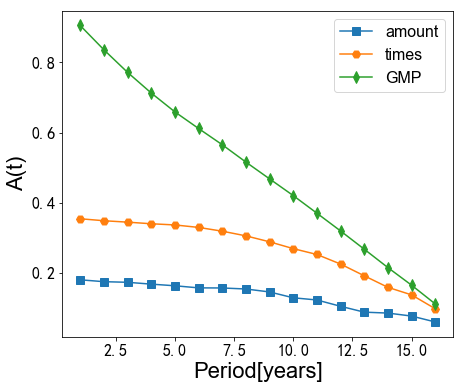

In [94]:
x=np.arange(1,17)
plt.figure(figsize=(7,6))
plt.plot(x,meanA,label='amount',marker='s',markersize=8)
plt.plot(x,meanT,label='times',marker='H',markersize=8)
plt.plot(x,meanG,label='GMP',marker='d',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Period[years]',font2)
plt.ylabel('A(t)',font2)
plt.legend(prop=font1)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/Fig6_b1Atcity.pdf', bbox_inches='tight')

In [88]:
####计算城市自己的相关性 Ai(Dt) = 1DjiD2Xtji(t)ji(tzDt)
def AnumT(data,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值  
    POP = data.iloc[m:m+1,0:18].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
    a = 0
    for xx in range(len(POP)):
        a += POP[xx]**2
    for t in range(1,11):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,0:len(pop)-t].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data.iloc[m:m+1,t:18].fillna(0).values[0]
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [89]:
###计算所有城市的delta t 时间序列相关性，并取均值###
TCity_A = []###投资金额，投资次数，GDP相关性
TCity_T = []
TCity_G = []
for n in range(len(cityM)):
    TCity_A.append(AnumT(dfSami_A.T,n))
    TCity_T.append(AnumT(dfSami_T.T,n))
    TCity_G.append(AnumT(dfSami_G.T,n))
dfT_A=pd.DataFrame(TCity_A)
dfT_T=pd.DataFrame(TCity_T)
dfT_G=pd.DataFrame(TCity_G)

meanTA = dfT_A.mean()
meanTT = dfT_T.mean()
meanTG = dfT_G.mean()

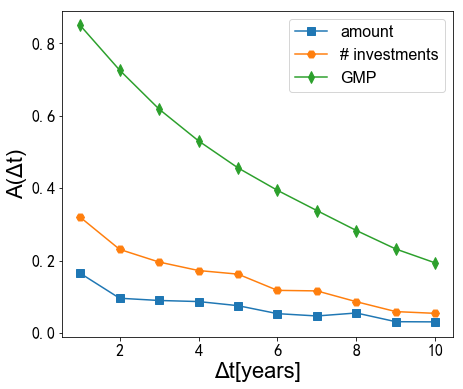

In [93]:
x=np.arange(1,11)
plt.figure(figsize=(7,6))
plt.plot(x,meanTA,label='amount',marker='s',markersize=8)
plt.plot(x,meanTT,label='# investments',marker='H',markersize=8)
plt.plot(x,meanTG,label='GMP',marker='d',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/Fig6_b2AdelT_city.pdf', bbox_inches='tight')

In [75]:
####计算城市两者之间的相关性 ######
def AnumT2(data,data2,pop,m):###m代表第几行的城市
    corrCity = []###记录城市的相关性值  
#     POP = data.iloc[m:m+1,0:18].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
#     a = 0
#     for xx in range(len(POP)):
#         a += POP[xx]**2
    for t in range(1,11):
        Acity = [] ###记录每两年间的情况
        pop1 = data.iloc[m:m+1,0:len(pop)-t].fillna(0).values[0]###时间序列长度必须一致，每次往后挪一列
        pop2 = data2.iloc[m:m+1,t:18].fillna(0).values[0]
        a1=0
        a2=0
        for xx in range(len(pop1)):
            a1+=pop1[xx]**2
            a2+=pop2[xx]**2
        a=(a1**0.5)*(a2**0.5)
        b=0
        for j in range(len(pop1)):
            b+=pop1[j]*pop2[j]
        if a==0:
            corrCity.append(0)
        else:
            corrCity.append(b/a)
    return(corrCity)

In [80]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_AT = []
TCity_AG = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_AT.append(AnumT2(dfSami_A.T,dfSami_T.T,inv_times,nn))
    TCity_AG.append(AnumT2(dfSami_A.T,dfSami_G.T,gdp,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_AT=pd.DataFrame(TCity_AT)
dfT_AG=pd.DataFrame(TCity_AG)

# meanTA = dfT_A.mean()
meanTAT = dfT_AT.mean()
meanTAG = dfT_AG.mean()

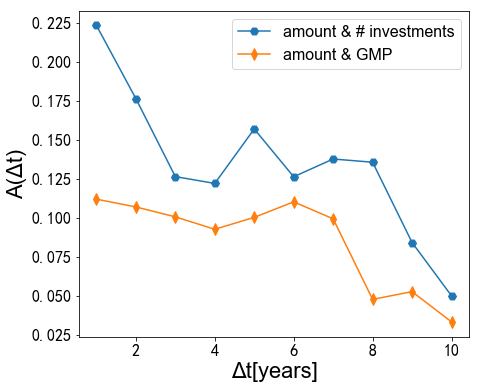

In [81]:
x=np.arange(1,11)
plt.figure(figsize=(7,6))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTAT,marker='H',label='amount & # investments',markersize=8)
plt.plot(x,meanTAG,marker='d',label='amount & GMP',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/Fig6_b3(ΔA&TG-149).pdf', bbox_inches='tight')

In [82]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_GA = []
TCity_GT = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_GA.append(AnumT2(dfSami_G.T,dfSami_A.T,investment,nn))
    TCity_GT.append(AnumT2(dfSami_G.T,dfSami_T.T,inv_times,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_GA=pd.DataFrame(TCity_GA)
dfT_GT=pd.DataFrame(TCity_GT)

# meanTA = dfT_A.mean()
meanTGA = dfT_GA.mean()
meanTGT = dfT_GT.mean()

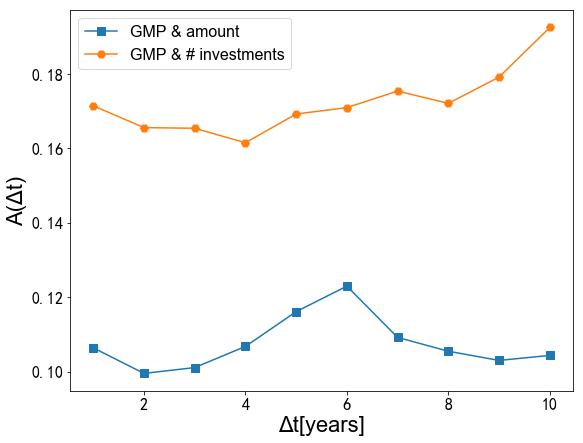

In [83]:
x=np.arange(1,11)
plt.figure(figsize=(9,7))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTGA,marker='s',label='GMP & amount',markersize=8)
plt.plot(x,meanTGT,marker='H',label='GMP & # investments',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 16,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/Fig6_b4(ΔA&TG149).pdf', bbox_inches='tight')

In [85]:
###计算所有城市的delta t 时间序列相关性，并取均值###
# TCity_A = []###投资金额，投资次数，GDP相关性
TCity_TA = []
TCity_TG = []
for nn in range(dataM.shape[0]):
#     TCity_A.append(AnumT2(dataAmount,investment,n))
    TCity_TA.append(AnumT2(dfSami_T.T,dfSami_A.T,investment,nn))
    TCity_TG.append(AnumT2(dfSami_T.T,dfSami_G.T,gdp,nn))
# dfT_A=pd.DataFrame(TCity_A)
dfT_TA=pd.DataFrame(TCity_TA)
dfT_TG=pd.DataFrame(TCity_TG)

# meanTA = dfT_A.mean()
meanTTA = dfT_TA.mean()
meanTTG = dfT_TG.mean()

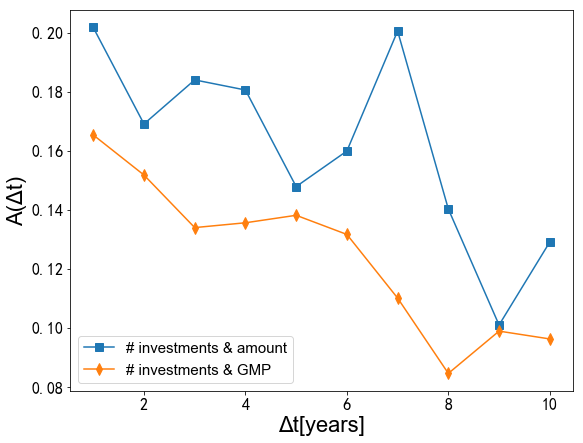

In [86]:
x=np.arange(1,11)
plt.figure(figsize=(9,7))
# plt.plot(x,meanTA,marker='o',label='amount')
plt.plot(x,meanTTA,marker='s',label='# investments & amount',markersize=8)
plt.plot(x,meanTTG,marker='d',label='# investments & GMP',markersize=8)
font2 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 22,
    }
font1 = {'family' : 'Arial',
    'weight' : 'normal',
    'size' : 15,
    }
plt.tick_params(labelsize=16) #刻度字体大小13
plt.xlabel('Δt[years]',font2)
plt.ylabel('A(Δt)',font2)
plt.legend(prop=font1)
plt.savefig('E:/文档系列/python 系列/picScalling/20201025NEW/Fig6_b5(ΔA&TG-149).pdf', bbox_inches='tight')